In [145]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/brianbarry/Desktop/computing/personal/galaxybrain')
from galaxybrain import ramsey, ising
from galaxybrain.plot_utils import rc_style, pltlabel, plot_ising_spectra, measure_over_temps, TEMP_COLOR_RANGE, colorcycler, noticks
rc_style()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from matplotlib.colors import ListedColormap as lcmap
import pandas as pd

CRIT_T = 2.26918531421

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ising model and scaling correlation analysis
Hamiltonian – rate of change of the condition of a dynamic physical system, or total energy in the system – is given by

$$ H = -J\sum_{ij} s_is_j $$

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Fricke:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

References:
- [matlab code](https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf)
- [python - how to find crit temp](https://rajeshrinet.github.io/blog/2014/ising-model/)

- orioginal tensor shape: (10000, 4096)
- 80% evals shape: 3276
- Taking off the last 2000: 1276

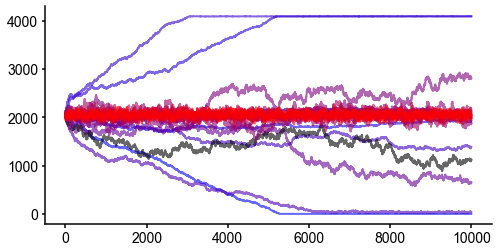

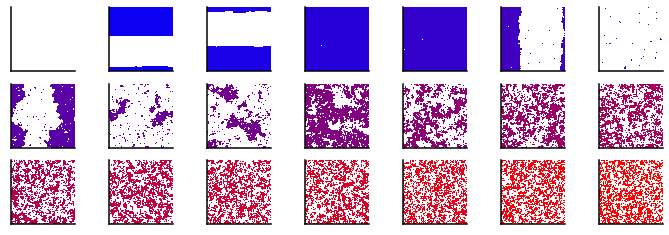

In [153]:
import h5py


ising_h5 = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/spikes/ising.hdf5', 'r') # keys := ['1.97', '2.07', '2.17', '2.27', '2.37', '2.47', '2.57']

COLORS = colorcycler(['blue', 'red'], len(ising_h5.keys()), default=False)
lws = {'2.27':4}
cs = {'2.27':'k'}
# all time series
plt.figure(figsize=(8,4))
for t,c in zip(ising_h5, COLORS):
    plt.plot(np.array(ising_h5[t]).sum(axis=-1).sum(axis=-1), label=t, color=cs.get(t,c), alpha=0.6)

# final frames
plt.figure(figsize=(12,4))
for i, (temp,c) in enumerate(zip(ising_h5, COLORS)):
    plt.subplot(3, 7, i+1)
    plt.imshow(ising_h5[temp][-1], cmap=lcmap(['w', c]))
    noticks()

# PSD

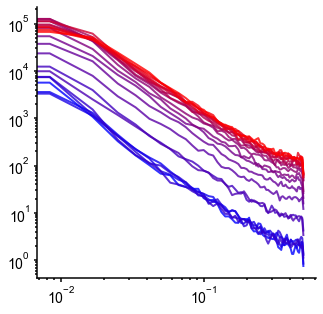

In [61]:
from neurodsp.spectral import compute_spectrum


psds = []
FS       = 1
NPERSEG  = 120 #400
NOVERLAP = NPERSEG/2 #int(.8*NPERSEG)
for temp in ising_h5:
    ts = np.array(ising_h5[temp]).sum(axis=-1).sum(axis=-1)
    f, spec = compute_spectrum(ts, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)
    psds.append(spec)
    
freqs = f
psds = np.array(psds)
plt.figure(figsize=(5,5))

for spec, temp,c in zip(psds, ising_h5, COLORS):
    plt.loglog(freqs, spec, label=temp, color=c, alpha=0.8)

# E Spec

take first n rows (e.g 30  -- > (4000, 30) ) and make sure number of pcs returned is n

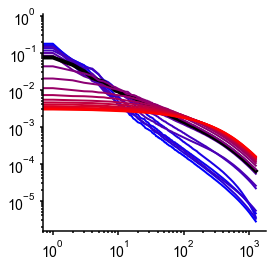

In [97]:
evals = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/ising_pca/ising_evals.hdf5', 'r') # keys := ['1.97', '2.07', '2.17', '2.27', '2.37', '2.47', '2.57']
CUT_OFF = -2000
evals = np.array([evals[t][:CUT_OFF] for t in evals])
plt.figure()
for e,t,c in zip(evals, ising_h5, COLORS):
    plt.loglog(e, color=cs.get(t,c), lw=lws.get(t, 2))

# FOOOF measures

In [156]:
from ramsey import fooofy


def plot_fooof_measures(components, spec, fitting_ranges):
    """
    scatter plot of exponents, errors, offsets across temperatures
    
    -- input --
    components: x axis of spectrum frequencies or PCs
    spec: spectral values, of shape (n_temps, n_val)
    fitting_ranges: list of lists like [[low, high]...]
    """
    for f_range in fitting_ranges:
        plt.figure(figsize=(12,4))
        for [i, val], name in zip(enumerate(fooofy(components, spec, f_range)), ['exponent', 'error', 'offset']):
            plt.subplot(1,3,i+1)
            plt.scatter(temps, val, c=COLORS, s=30)
            plt.title(name)
            plt.axvline(CRIT_T)
        plt.suptitle(f'range: {f_range}')

### PSD

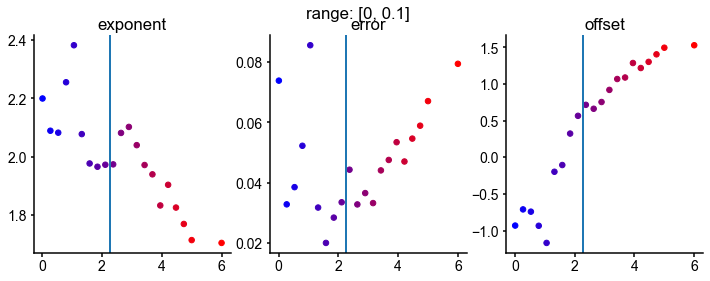

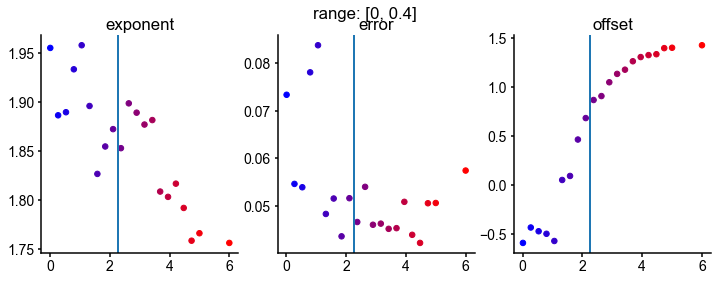

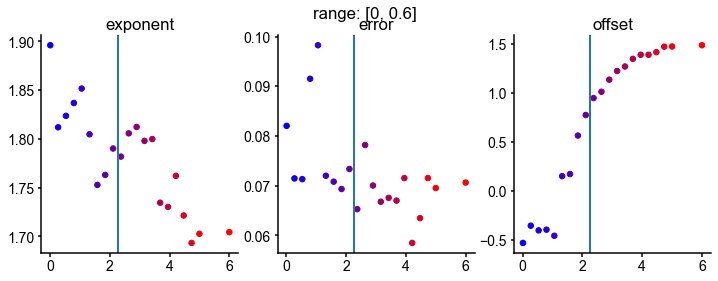

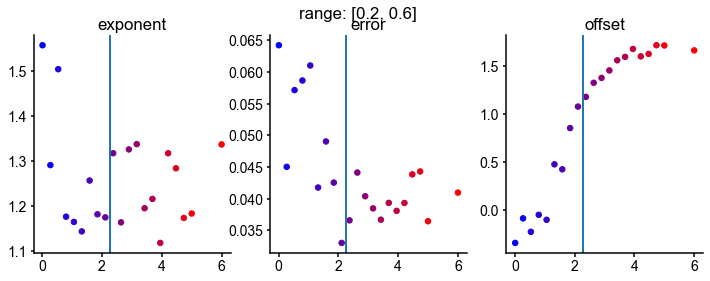

In [160]:
plot_fooof_measures(freqs, psds, [[0, 0.1], [0, 0.4], [0, 0.6], [0.2,0.6]])

### ES

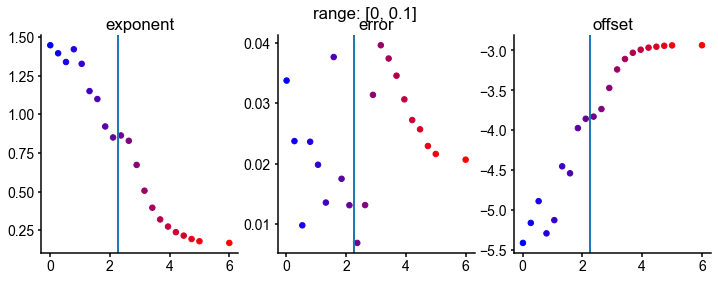

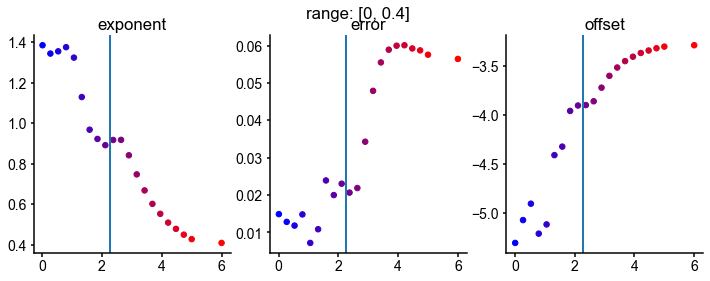

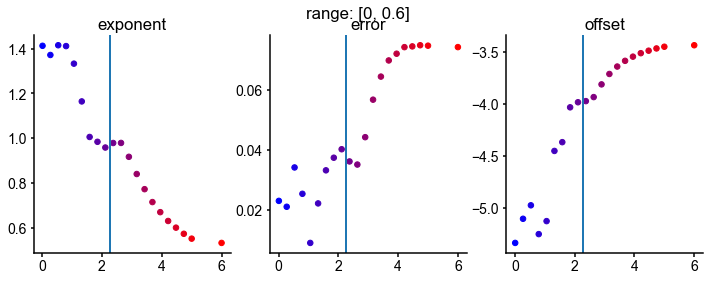

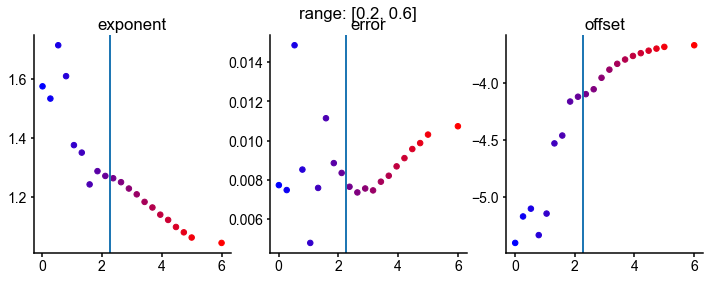

In [159]:
plot_fooof_measures(np.linspace(0,1, len(evals.T)), evals, 
                    [[0, 0.1], [0, 0.4], [0, 0.6], [0.2,0.6]])

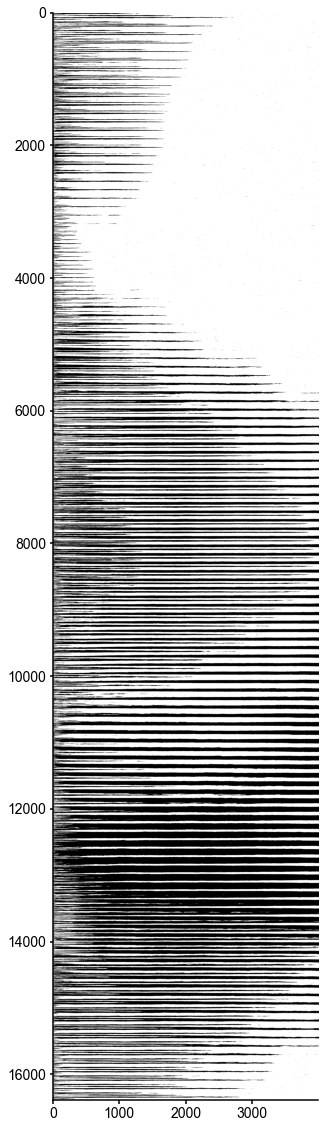

In [5]:
plt.figure(figsize=(10,20))
plt.imshow(history[4].reshape(4000, -1).T)
plt.gray()

# Diagram

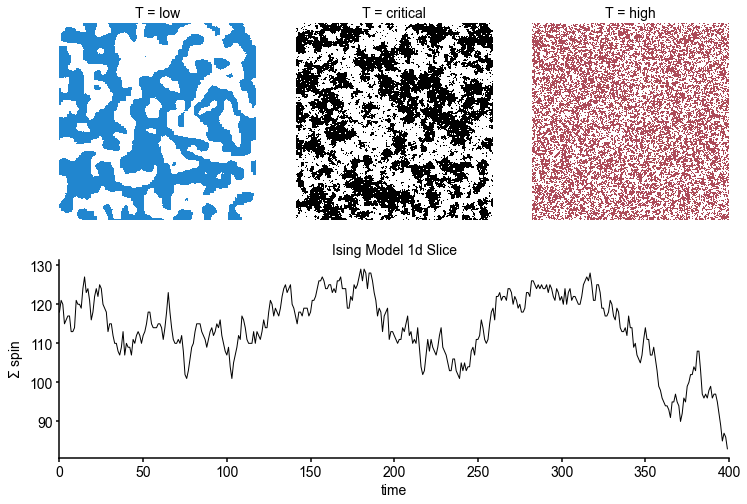

In [19]:
cs = TEMP_COLOR_RANGE[0], 'k', TEMP_COLOR_RANGE[1] #cold, crit, hot
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,3)
for (i, temp), c in zip(enumerate([0.1, 'critical', 5]), cs):
    # plt.subplot(1,3,i+1)
    ax = fig.add_subplot(gs[0,i])
    grid = ising.metro_ising(N=256, T=temp, runtime=500)
    ax.imshow(grid[499], cmap=lcmap(['w',c])) # plot last frame
    title_map = {0.1:'low', 'critical':'critical', 5:'high'}
    plt.title(f'T = {title_map[temp]}', fontsize=14)
    ax.axis('off')
    if temp == 'critical':
        ax = fig.add_subplot(gs[1,:])
        ising_raster_slice = pd.DataFrame(grid[100:][:,178]) # shape (400, 256)

        ax.plot(np.sum(ising_raster_slice.T), c, lw=1)
        plt.xlim([0,400])
        pltlabel('Ising Model 1d Slice', 'time', r'$\Sigma$ spin')
    
plt.savefig('../fig/ising/grid_samples.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Subsampling analysis from cluster

Iterated 5 times for each temperature in: 0.50, 1.00, 1.27, 1.47, 1.67, 1.87, 2.07, 2.27, 2.47, 2.67, 2.87, 3.07, 3.27, 5.00

In [20]:
from galaxybrain.data_utils import load_results

sim_data = load_results('../data/experiments/expSIM2', kind='sim')
all_temps = [k for k in sim_data if k != 'meta']

{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}


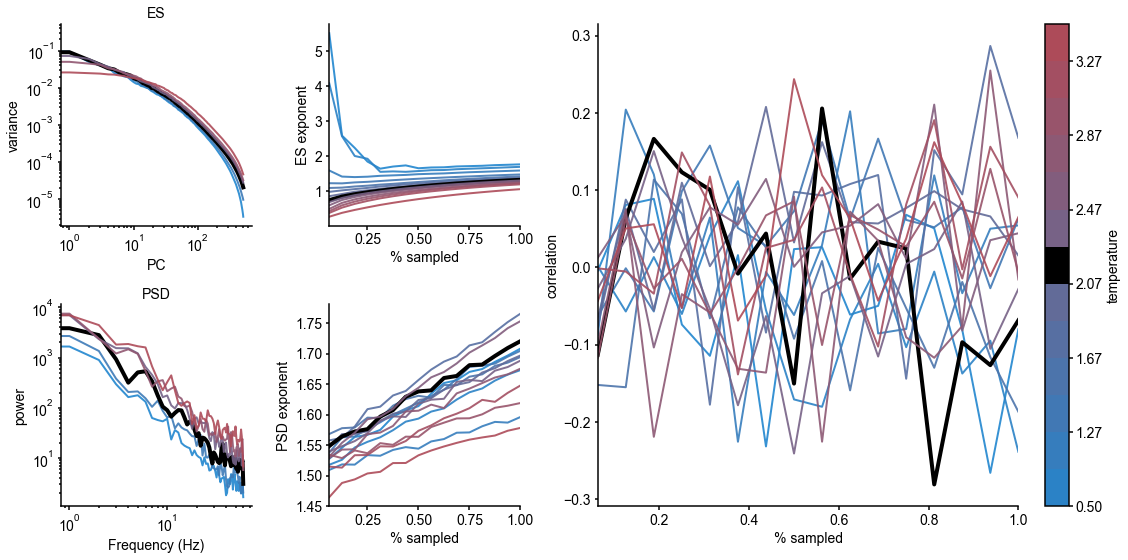

In [132]:
sample_temps = ['1.67', '1.87', '2.27', '2.67', '3.07', '5.00'] # avoid big drop off with very low temps

fig = plt.figure(figsize=(16,8))
gs = GridSpec(2,3, width_ratios=[1,1, 2.75])

for (i, spec), labels in zip(enumerate(['eigs', 'pows']), 
                           [['ES','PC', 'variance'], ['PSD','Frequency (Hz)', 'power']]):
    ax = fig.add_subplot(gs[i, 0])
    plot_ising_spectra(sim_data, spec, sample_temps, ax=ax)
    pltlabel(*labels)

for (i, spec), labels in zip(enumerate(['pca_m', 'ft_m']), 
                           [['','% sampled', 'ES exponent'], ['','% sampled', 'PSD exponent']]):
    ax = fig.add_subplot(gs[i, 1])
    measure_over_temps(sim_data, spec, all_temps, ax=ax)
    pltlabel(*labels)
    
ax = fig.add_subplot(gs[:,2])
measure_over_temps(sim_data, 'pearson_corr', all_temps, ax, colorbar=True)
pltlabel('', '% sampled', 'correlation')
fig.tight_layout()

plt.savefig('../fig/ising/specs_corr.png', bbox_inches='tight', pad_inches=0.0, dpi=400)